- [visiualize center loss MNIST](https://github.com/jxgu1016/MNIST_center_loss_pytorch)
### Detail
- paper [here](http://ydwen.github.io/papers/WenECCV16.pdf)
- not just separate but discriminate 
- softmax loss = cross entrophy
- dataset MegaFace also [Labeled Faces in the Wild (LFW), and YouTube Faces (YTF)]
- use 5 landmarks (two eyes, nose and mouth corners) for similarity transformation by this [algorithm](https://arxiv.org/pdf/1604.02878.pdf)
- cropped to 112 × 96

TODO
- pretrain with softmax loss
- MTCNN to face align
- freeze/unfreeze
- 

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from exitai.learner import Learner
from exitai.callbacks import Callback
from exitai.losses import CenterLoss
from sklearn.decomposition import PCA
import numpy as np
import random

In [2]:
class TestDataset(Dataset):
    def __init__(self, dataset, length=10):
        self.dataset = dataset
        self.length = length
    def __getitem__(self, index):
        return random.choice(self.dataset)
    def __len__(self):
        return self.length

In [3]:
transform_train = transforms.Compose([
#                                    transforms.RandomAffine(15, scale=(.9,1.2)), # TODO add me
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = TestDataset( # TODO remove Test data
                    datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train), 
                    500)
dataset_test = TestDataset( # TODO remove Test data
                    datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_test), 
                    500)
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_embedding = nn.Linear(500, 2)
        self.fc_classes = nn.Linear(2, 10)
        
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc_1(output)
        vector_embedding = self.fc_embedding(output)
        output = self.fc_classes(vector_embedding)
        return output, vector_embedding
    
    def name(self):
        return "LeNet"

In [5]:
def visualize(vectors_embedding, target, epoch):
    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    plt.clf()
    for i in range(10):
        plt.plot(vectors_embedding[target == i, 0], vectors_embedding[target == i, 1], '.', c=c[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc = 'upper right')
    plt.xlim(xmin=-18,xmax=18)
    plt.ylim(ymin=-18,ymax=18)
    plt.text(-7.8,7.3,"epoch=%d" % epoch)
#     plt.savefig('./images/epoch=%d.jpg' % epoch)
    plt.draw()
    plt.pause(0.001)

In [60]:
class Plottracker(Callback):
    def __init__(self):
        self.target = []
        self.vectors_embedding = []
        self.epoch = 0
        
    def add(self, target, vector_embedding):
        self.target.append((target))
        self.vectors_embedding.append((vector_embedding))
        
    def on_epoch_end(self, phase, num_data):
        vectors_embedding = torch.cat(self.vectors_embedding, 0)
        targets = torch.cat(self.target, 0)
        self.epoch += 1
        visualize(vectors_embedding.data.cpu().numpy(), targets.data.cpu().numpy(), self.epoch)

In [69]:
plottracker = Plottracker()
center_loss = CenterLoss(10, 2)
def model_loss_func(input_data, model, phase):
    input, target = input_data
    output, vector_embedding = model(input)
    plottracker.add(target, vector_embedding)
    
    # Loss
    loss = F.cross_entropy(output, target) + 0.1*center_loss(target, vector_embedding)
    return output, loss

In [70]:
###### Learning Rate Finder ######

# model = LeNet()
# learner = Learner(data_loader_train, data_loader_test, model)
# learner.lr_find(model_loss_func, 1e-7, 0.3)

In [71]:
class CenterLossOptimHook(Callback):
    def __init__(self):
        self.optim = torch.optim.SGD(center_loss.parameters(), lr=0.5)
    def on_batch_end(self, phase, input_data, output, loss):
        if phase is 'train':
            self.optim.step()
            self.optim.zero_grad()
            

---- epoch:0 ------
   [train] Average loss: 6.5791, acc: 11.40%


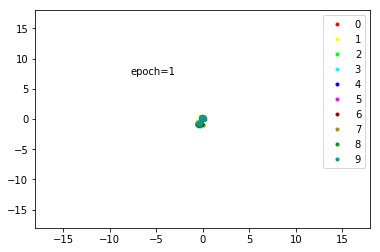

---- epoch:1 ------
   [train] Average loss: 1.9163, acc: 21.00%


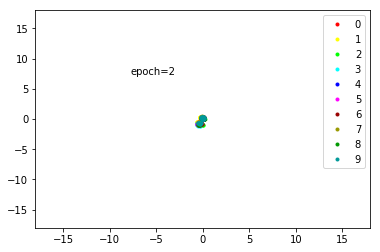

---- epoch:2 ------
   [train] Average loss: 1.8663, acc: 13.20%


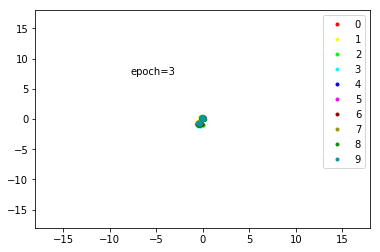

---- epoch:3 ------
   [train] Average loss: 1.8747, acc: 10.80%


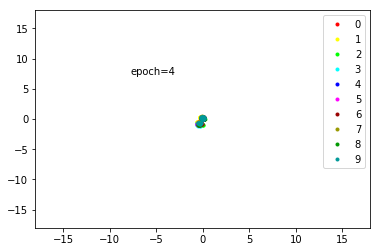

---- epoch:4 ------
   [train] Average loss: 1.8950, acc: 7.80%


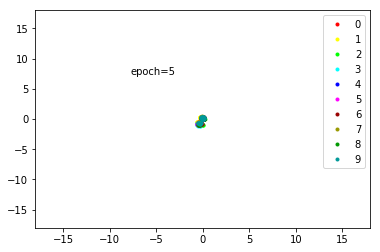

In [72]:
model = LeNet()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, 0.002, num_epochs=5, callbacks=[plottracker, CenterLossOptimHook()], is_run_test=False)

In [17]:
a = torch.tensor([[1,2],[3,4],[5,6]])
a.new_empty((2,3)).fill_(100)

(tensor([[100, 100, 100],
         [100, 100, 100]]), tensor([[1, 2],
         [3, 4],
         [5, 6]]))